In [1]:
import numpy as np
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
my_path = '/home/lorenzp/adversialml/src/'

advs = torch.load(my_path + '/data/attacks/run_1/cif10/wrn_28_10_10/bim/images_adv')
images = torch.load(my_path + '/data/attacks/run_1/cif10/wrn_28_10_10/bim/images')

In [8]:
def plot_spectrum(fft_im, vmin, scale_factor):
    fshift0 = np.fft.fftshift(fft_im) #shifts the zero-frequency component to the center of the spectrum
    magnitude_spectrum = (np.log10(np.abs(fshift0*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)), vmin=vmin)
    plt.imshow(np.abs(magnitude_spectrum),  vmin=vmin)
    
def plot_spectrum_diff(fft1, fft2, scale_factor):
    norm = fft1-fft2
    diff = np.abs(norm)
    
    magnitude_spectrum = (np.log10(np.abs(diff*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)))
    plt.imshow(np.abs(magnitude_spectrum), cmap='Blues')
    return norm
                          
def plot_im(im):
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
                          
def plot_diff(im1, im2, scale_factor=0):
    im1 = im1.numpy()
    im2 = im2.numpy()
    diff = np.abs(im1-im2)
    #print(np.linalg.norm(diff))
    magnitude_spectrum = (np.log10(np.abs(diff*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    plt.imshow(np.transpose(magnitude_spectrum, (1, 2, 0)))  
    return np.linalg.norm(diff)

def avg_projection_fft(x):
   
    x_image = np.fft.fft2(x)
    #calculate the max for each pixel over the channels
    max_image = x_image[0,:,:].copy()
    #x_image = np.abs(x_image) #only look at the magnitude
    n = len(max_image)
    for i in range(n):
        for j in range(n):
            max_image[i,j] = sum(np.abs(x_image[:,i,j])) / 3
    return max_image


def mean_projection_fft(x):
    x_image = np.fft.fft2(x)
    # calculate the mean for each pixel over the channels
    mean_image = x_image[0,:,:].copy()
    # x_image = np.abs(x_image) #only look at the magnitude
    row, col = mean_image.shape
    for i in range(row):
        for j in range(col):
            mean_image[i,j] = np.mean( np.abs(x_image[:,i,j]) )
    return mean_image


def max_projection_fft(x):
   
    x_image = np.fft.fft2(x)
    #calculate the max for each pixel over the channels
    max_image = x_image[0,:,:].copy()
    #x_image = np.abs(x_image) #only look at the magnitude
    n = len(max_image)
    for i in range(n):
        for j in range(n):
            max_image[i,j] = max(np.abs(x_image[:,i,j]))
    return max_image

def max_proj(image):
    (_,n,m) = np.shape(image)
    new_image = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            new_image[i,j] = np.max(image[:,i,j])
    return new_image

def average_spectrum(images):
    im_sum = images[0]
    for i in range(1,999):
        img = images[i]
        img = np.abs(np.fft.fft2(img))
        #img = max_proj(img)
        if np.max(img)>0:
            img *= 1/np.max(img)
            im_sum += img
    return im_sum/1000

#PMI

def calc_MI(x, y):
    c_xy = np.histogram2d(x, y)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def patch(image, start_x, start_y, size):
    patch_im = image[:,start_x:start_x+size,start_y:start_y+size].numpy()
    return patch_im

def calculate_pmi_image(image, noise, patch_size):
    pmi_image = np.zeros((24,24))
    for i in range(24):
        for j in range(24):
            pmi_image[i,j] = calc_MI(patch(image, i,j,patch_size).flatten(), patch(noise, i,j,patch_size).flatten())
    return pmi_imag

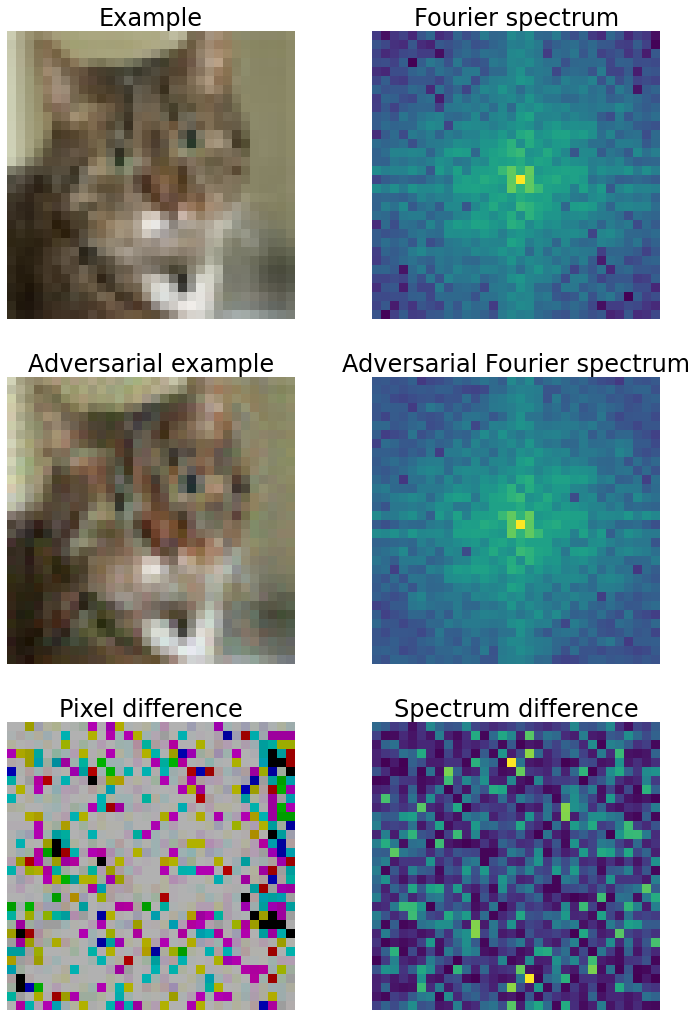

In [9]:
plt.figure(figsize=(12,18))
im_num = 5
# attack = advs[3]
im = images[im_num].cpu()
ad = advs[im_num].cpu()

#normal image
plt.subplot(3,2,1)
plt.title('Example', fontsize=24)
plot_im(im)
plt.axis('off')
plt.subplot(3,2,2)
plt.title('Fourier spectrum', fontsize=24)
fft = mean_projection_fft(im) #max_projection_fft(im)
ad_fft = mean_projection_fft(ad) #max_projection_fft(ad)
# ad_fft *= 1/np.max(ad_fft)
# fft *= 1/np.max(fft

scale_factor=5
m_n = (np.log10(np.abs(np.fft.fftshift(np.abs(fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
vmin = min(np.min(m_n),np.min(m_a))

plot_spectrum(fft, vmin=vmin, scale_factor=5)
plt.axis('off')
#plt.colorbar()
#adversarial image
plt.subplot(3,2,3)
plt.title('Adversarial example', fontsize=24)
plot_im(ad)
plt.axis('off')
plt.subplot(3,2,4)
plt.title('Adversarial Fourier spectrum', fontsize=24)


plot_spectrum(ad_fft, vmin=vmin,scale_factor=5)
plt.axis('off')
#plt.colorbar()
#differences
plt.subplot(3,2,5)
plt.title('Pixel difference', fontsize=24)
norm = plot_diff(im, ad, scale_factor=4)
plt.axis('off')
plt.subplot(3,2,6)
plt.title('Spectrum difference', fontsize=24)
#norm = plot_spectrum_diff(fft, ad_fft, scale_factor=5)
plt.imshow(np.abs(ad_fft-fft))
plt.axis('off')
#plt.colorbar()
plt.savefig('one_image_analysis', bbox_inches='tight', pad_inches=0.1)
im_num+=1

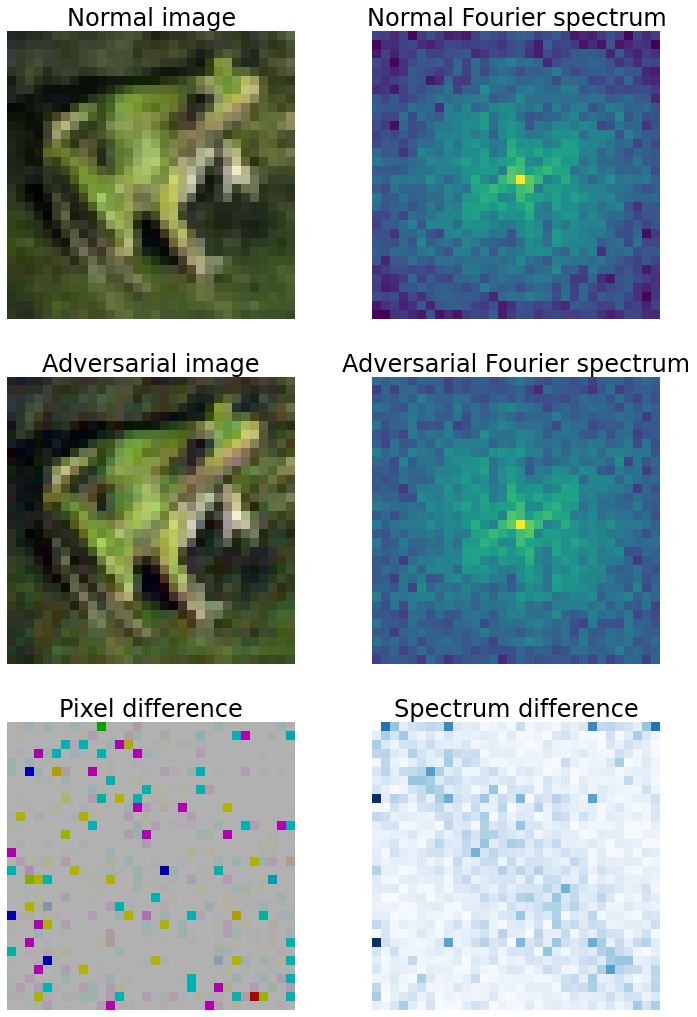

In [5]:
plt.figure(figsize=(12,18))
im_num = 2
# attack = attacks[3]
im = images[im_num].cpu()
ad = advs[im_num].cpu()


#normal image
plt.subplot(3,2,1)
plt.title('Normal image', fontsize=24)
plot_im(im)
plt.axis('off')
plt.subplot(3,2,2)
plt.title('Normal Fourier spectrum', fontsize=24)
fft = max_projection_fft(im)
ad_fft = max_projection_fft(ad)
ad_fft *= 1/np.max(ad_fft)
fft *= 1/np.max(fft)
scale_factor=5
m_n = (np.log10(np.abs(np.fft.fftshift(np.abs(fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
vmin = min(np.min(m_n),np.min(m_a))

plot_spectrum(fft, vmin=vmin, scale_factor=5)
plt.axis('off')
#plt.colorbar()
#adversarial image
plt.subplot(3,2,3)
plt.title('Adversarial image', fontsize=24)
plot_im(ad)
plt.axis('off')
plt.subplot(3,2,4)
plt.title('Adversarial Fourier spectrum', fontsize=24)


plot_spectrum(ad_fft, vmin=vmin,scale_factor=5)
plt.axis('off')
#plt.colorbar()
#differences
plt.subplot(3,2,5)
plt.title('Pixel difference', fontsize=24)
norm = plot_diff(im, ad, scale_factor=4)
plt.axis('off')
plt.subplot(3,2,6)
plt.title('Spectrum difference', fontsize=24)
#norm = plot_spectrum_diff(fft, ad_fft, scale_factor=5)
plt.imshow(np.abs(ad_fft-fft), cmap='Blues')
plt.axis('off')
#plt.colorbar()
plt.savefig('one_image_analysis')

In [6]:
my_path = '/home/lorenzp/adversialml/src/src'

originals = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/bim/images')
deepfools= torch.load(my_path +  '/data/attacks/run_5/cif10/wrn_28_10_10/df/images_adv')
bims  =torch.load(my_path +  '/data/attacks/run_5/cif10/wrn_28_10_10/bim/images_adv')
cws  = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/cw/images_adv')
pgds = torch.load(my_path +  '/data/attacks/run_5/cif10/wrn_28_10_10/pgd/images_adv')
fgsms  = torch.load(my_path +  '/data/attacks/run_5/cif10/wrn_28_10_10/fgsm/images_adv')
aa  = torch.load(my_path +  '/data/attacks/run_5/cif10/wrn_28_10_10/std/8_255/images_adv')

o_fgsms     = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/fgsm/images')
o_bims      = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/bim/images')
o_pgds      = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/pgd/images')
o_aa        = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/std/8_255/images')
o_cws       = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/cw/images')
o_deepfools = torch.load(my_path + '/data/attacks/run_5/cif10/wrn_28_10_10/df/images')

attacks = [originals, fgsms, bims, pgds, aa, deepfools, cws]
origs   = [o_fgsms, o_bims, o_pgds, o_aa, o_deepfools, o_cws]
attack_name = ['normal','FGSM', 'BIM', ' PGD', 'AA',  'Deepfool', 'C&W']

In [7]:
plt.figure(figsize=(8,17))
#fig.subplots_adjust(hspace=1, wspace=1)
n = 9
mins = []
# dmins = []
# dmaxs = []
# for i in range(7):
#     attack = attacks[i]
    
#     im = attack[n].cpu()
#     ad_fft = max_projection_fft(im)
#     ad_fft *= 1/np.max(ad_fft)
#     scale_factor=5
#     m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
#     if i == 0:
#         m_n = m_a
    
#     mins.append(np.min(m_a))
#     dmins.append(np.min(np.abs(m_a-m_n)))
#     dmaxs.append(np.max(np.abs(m_a-m_n)))
# dmax = max(dmaxs)
# dmin = min(dmins)
for i in range(7):
    attack = attacks[i]
    im = attack[n].cpu()
    ad_fft = max_projection_fft(im)
    ad_fft *= 1/np.max(ad_fft)
    scale_factor=5
    m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    if i == 0:
        orig = im
        fft = ad_fft
        m_n = m_a
    vmin = min(mins)
    plt.subplot(7,4,4*i+1)
    plt.subplots_adjust(hspace=0, wspace=0, bottom=0.01)
    #plt.subplots_adjust( wspace=0,hspace=0,top=0.6)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    if i== 0:
        plt.title('Image')
    plt.ylabel(attack_name[i],fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(7,4,4*i+2)
    plt.subplots_adjust( wspace=0,hspace=0,top=0.6, bottom=0.01)
    scale_factor=5
    fshift0 = np.fft.fftshift(ad_fft) #shifts the zero-frequency component to the center of the spectrum
    magnitude_spectrum = (np.log10(np.abs(fshift0*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)), vmin=vmin)
    plt.imshow(np.abs(magnitude_spectrum),  vmin=vmin)
    if i== 0:
        plt.title('Spectrum')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(7,4,4*i+3)
    #plt.subplots_adjust(hspace=0, wspace=0, bottom=0.01)
    plt.subplots_adjust( wspace=0,hspace=0,top=0.6, bottom=0.01)
    plt.imshow(np.abs(ad_fft-fft))
    plt.xticks([])
    plt.yticks([])
    if i== 0:
        plt.title('Spectrum difference')

        
    plt.subplot(7,4,4*i+4)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    if i > 0:
        ax=plt.gca() #get the current axes
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(ax=ax, shrink=0.95)
        
    #plt.subplots_adjust(hspace=0, wspace=0)
    plt.subplots_adjust( wspace=0,hspace=0,top=0.6, bottom=0.01)
plt.savefig('attack_compare', bbox_inches='tight', pad_inches=0.1)


ValueError: min() arg is an empty sequence

<Figure size 576x1224 with 0 Axes>

In [ ]:
my_path = '/home/lorenzp/adversialml/src/src'
originals = torch.load(my_path + '/data/attacks/run_2/cif10/wrn_28_10_10/bim/images')
aa_originals  = torch.load(my_path +  '/data/attacks/run_1/cif10/wrn_28_10_10/std/8_255/images')

In [8]:
# idx_eq = []

# for idx, orig in enumerate(originals):
#     for idx2, aa_orig in enumerate(aa_originals):
#         eq = np.array_equal(orig, aa_orig)
#         if eq:
#             idx_eq.append((idx,idx2))

# len(idx_eq)        
#         import pdb; pdb.set_trace()

In [9]:
n = 9
mins = []
dmins = []
dmaxs = []
for i in range(7):
    attack = attacks[i]
    
    im = attack[n].cpu()
    ad_fft = max_projection_fft(im)
    ad_fft *= 1/np.max(ad_fft)
    scale_factor=5
    m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    if i == 0:
        m_n = m_a
    
    mins.append(np.min(m_a))
    dmins.append(np.min(np.abs(m_a-m_n)))
    dmaxs.append(np.max(np.abs(m_a-m_n)))
dmax = max(dmaxs)
dmin = min(dmins)

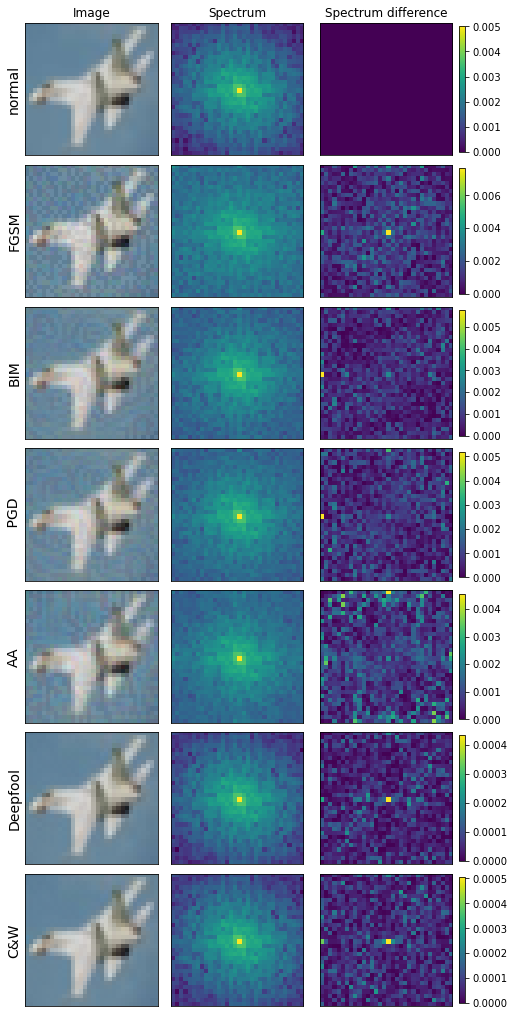

In [10]:
# plt.figure(figsize=(8,17))
#fig.subplots_adjust(hspace=1, wspace=1)

fig, axes = plt.subplots(7,3, figsize=(7,14), constrained_layout=True,)
# fig, axes = plt.subplots(7,3, figsize=(7,14), gridspec_kw={'wspace':0.1, 'hspace':0.1, 'top':0.9,'bottom':0.11})

# fig.tight_layout()

# ax.xaxis.set_major_locator(plt.NullLocator())
# ax.yaxis.set_major_locator(plt.NullLocator())

for row in range(7):
    for col in range(3):    

        ax = axes[row, col]
        
#         ax.subplots_adjust(hspace=0.5)

        ax.set_xticks([])
        ax.set_yticks([])
        
        attack = attacks[row]
        im = attack[n].cpu()
        ad_fft = max_projection_fft(im)
        ad_fft *= 1/np.max(ad_fft)
        scale_factor=5
        m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
        if col == 0 and row == 0:
            orig = im
            fft = ad_fft
            m_n = m_a
        vmin = min(mins)
        
        if col == 0:
            ax.imshow(np.transpose(im.numpy(), (1, 2, 0)))
            ax.set_ylabel(attack_name[row], fontdict={'fontsize': 14, 'fontweight': 'medium'})

            if row== 0:
                ax.set_title('Image')

        if col == 1:
            scale_factor=5
            fshift0 = np.fft.fftshift(ad_fft) #shifts the zero-frequency component to the center of the spectrum
            magnitude_spectrum = (np.log10(np.abs(fshift0*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
            #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)), vmin=vmin)
            ax.imshow(np.abs(magnitude_spectrum),  vmin=vmin)
            if row == 0:
                ax.set_title('Spectrum')

        if col == 2:
            spec_dif = np.abs(ad_fft-fft)
            if row == 0:
#                 spec_dif = np.zeros_like(spec_dif, dtype=np.int32)
                im_spec = ax.imshow(spec_dif, vmin=0, vmax=0.005)
            else:
                im_spec = ax.imshow(spec_dif, vmin=0, )
#                 import pdb; pdb.set_trace()
            
            plt.colorbar(im_spec, ax=ax, shrink=0.95)

            if row== 0:
                ax.set_title('Spectrum difference')
            
            
# fig.savefig('attack_compare', bbox_inches='tight', dpi=300)
fig.savefig('attack_compare' + str(n) + '.pdf', bbox_inches='tight', dpi=300)
# fig.savefig('attack_compare.svg', bbox_inches='tight', dpi=300)

normal
FGSM
row:  1 2070 2070
(32, 32)
BIM
row:  2 2037 2037
(32, 32)
 PGD
row:  3 2033 2033
(32, 32)
AA
row:  4 2161 2161
(32, 32)
Deepfool
row:  5 2048 2048
(32, 32)
C&W
row:  6 2048 2048
(32, 32)


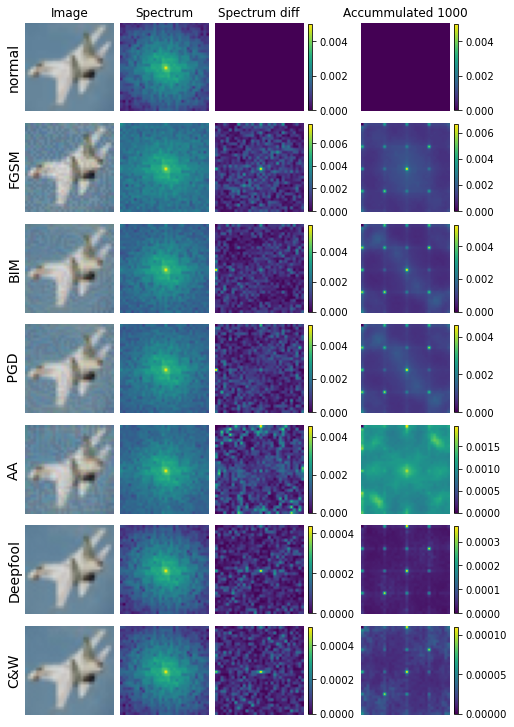

In [38]:
# plt.figure(figsize=(8,17))
#fig.subplots_adjust(hspace=1, wspace=1)
n = 9
nr_accumulated = 1000
rows = 7
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(7,10), constrained_layout=True,)
# fig, axes = plt.subplots(7,3, figsize=(7,14), gridspec_kw={'wspace':0.1, 'hspace':0.1, 'top':0.9,'bottom':0.11})


def average_spectrum( images, nr_accumulated ):
#     im_sum = images[0].cpu()
    im_sum = np.zeros((3,32,32))
    for i in range( 0, nr_accumulated ):
        img = images[i].cpu()
#         img = np.abs( np.fft.fft2(img) )
        img = max_proj(img)
        if np.max(img) > 0:
            img *= 1/np.max( img )
            im_sum += img
        
    return (im_sum/nr_accumulated).transpose((1,2,0))


def accumulated(att_im, originals, row, n=9, max_im=10):
    if row == 0:
        return np.zeros((32,32))
    
    if n > max_im:
        print("Err: n > max_im")
    
    ad_ffts = []
    spec_diffs = []
    sel_att = att_im[:max_im]
    sel_ori = originals[:max_im]
    tmp = np.zeros((32,32))
    
    
    
    for idx, im in enumerate(sel_att):
        ad_fft = max_projection_fft( im.cpu() )
        ad_fft *= 1/np.max( ad_fft )
        
        o_fft = max_projection_fft( sel_ori[idx].cpu() )
#         o_fft = avg_projection_fft( sel_ori[idx].cpu() )
        o_fft *= 1/np.max( o_fft )
        
        diff = np.abs(ad_fft - o_fft)
        tmp = tmp + diff

    return tmp / max_im




# def accumulated(att_im, originals, row, n=9, max_im=10):
    
#     if row == 0:
#         return np.zeros((32,32))
    
#     if n > max_im:
#         print("Err: n > max_im")
    
#     ad_ffts = []
#     spec_diffs = []
#     sel_att = att_im[:max_im]
#     sel_ori = originals[:max_im]
#     tmp = np.zeros((32,32))
#     for idx, im in enumerate(sel_att):
#         ad_fft = max_projection_fft( im.cpu() )
#         ad_fft *= 1/np.max( ad_fft )
        
#         o_fft = max_projection_fft( sel_ori[idx].cpu() )
# #         o_fft = avg_projection_fft( sel_ori[idx].cpu() )
#         o_fft *= 1/np.max( o_fft )
        
#         diff = np.abs(ad_fft - o_fft)
#         tmp = tmp + diff

#     return tmp / max_im
            


for row in range(rows):
    for col in range(cols):    
        ax = axes[row, col]

        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        
        
        attack = attacks[row]
            
        im = attack[n].cpu()
        ad_fft = max_projection_fft(im)
        ad_fft *= 1/np.max(ad_fft)
        scale_factor=5
        m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
        if col == 0 and row == 0:
            orig = im
            fft = ad_fft
            m_n = m_a
        vmin = min(mins)
        
        if col == 0:
            ax.imshow(np.transpose(im.numpy(), (1, 2, 0)))
            ax.set_ylabel(attack_name[row], fontdict={'fontsize': 14, 'fontweight': 'medium'})
            print(attack_name[row])
            
            if row== 0:
                ax.set_title('Image')

        if col == 1:
            scale_factor=5
            fshift0 = np.fft.fftshift(ad_fft) #shifts the zero-frequency component to the center of the spectrum
            magnitude_spectrum = (np.log10(np.abs(fshift0*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
            #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)), vmin=vmin)
            ax.imshow(np.abs(magnitude_spectrum),  vmin=vmin)
            if row == 0:
                ax.set_title('Spectrum')

        if col == 2:
            spec_dif = np.abs(ad_fft - fft)
#             print("---------------------------------")
#             print("spec_dif", spec_dif)
            if row == 0:
                im_spec = ax.imshow(spec_dif, vmin=0, vmax=0.005)
            else:
                im_spec = ax.imshow(spec_dif, vmin=0, )

            plt.colorbar(im_spec, ax=ax, shrink=0.96)

            if row== 0:
                ax.set_title('Spectrum diff')
    
        if col == 3:
            if row == 0:
                ax.set_title('Accummulated {}'.format(nr_accumulated))
                spec_dif = np.zeros_like(spec_dif, dtype=np.int32)
                im_acc = ax.imshow(spec_dif, vmin=0, vmax=0.005)
            else:
                print("row: ", row, len(origs[row-1]), len(attack))
                ori = origs[row-1]
                acc_im = accumulated(attack, ori, row, n=9, max_im=nr_accumulated)
#                 acc_im = average_spectrum(attack, nr_accumulated)
                print(acc_im.shape)
#                 print("acc_im: ", acc_im)
#                 calculated_mean.append(acc_im)
#                 im_acc = ax.imshow(acc_im, vmin=0, vmax=np.max(acc_im) )
                im_acc = ax.imshow(acc_im, vmin=0,  )
    
            plt.colorbar(im_acc, ax=ax, shrink=0.96)
        
# fig.savefig('attack_compare', bbox_inches='tight', dpi=300)
# fig.savefig('attack_compare_avg_' + str(nr_accumulated) + '.pdf', bbox_inches='tight', dpi=300)
# fig.savefig('attack_compare_acc_' + str(nr_accumulated) + '.pdf', bbox_inches='tight', dpi=300)

# fig.savefig('attack_compare.svg', bbox_inches='tight', dpi=300)

In [12]:
np.max(acc_im)

0.01552061259568695

In [13]:
np.min(acc_im)

2.5979218776228665e-17

In [ ]:
fig.savefig('attack_compare_acc.pdf', bbox_inches='tight', dpi=300)

In [18]:
len(range(1,1001))

1000